# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed-celeba-small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
    ])
    train_on_gpu = torch.cuda.is_available()
    print(train_on_gpu)
    GPU_NUM = 1
    DATA_LOADER_WORKERS=1

    if train_on_gpu:
        print('\nBATCH_LOADER num_workes for GPUs=', torch.cuda.device_count())
        DATA_LOADER_WORKERS= 4 * torch.cuda.device_count()
        print('\nDATA_LOADER_WORKERS=', DATA_LOADER_WORKERS)
    
    data_set = datasets.ImageFolder(root=data_dir, transform=transform)
    
    num_workers = DATA_LOADER_WORKERS

    # build DataLoaders for SVHN dataset
    data_loader = torch.utils.data.DataLoader(dataset=data_set,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


True

BATCH_LOADER num_workes for GPUs= 8

DATA_LOADER_WORKERS= 32


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

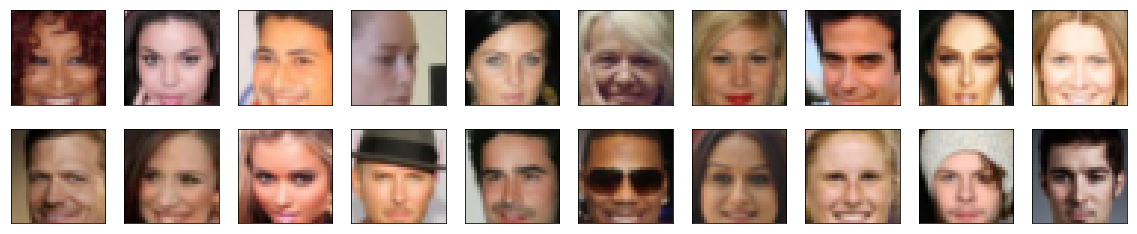

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    v_min, v_max = feature_range
    x = x * (v_max - v_min) + v_min
    
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9686)
Max:  tensor(0.6863)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [9]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        
        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        #16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)  
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) 
        # 4x4 out
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 2x2 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*8*2* 2, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        x = x.view(-1, self.conv_dim * 8*2*2 )
        
        out = self.fc(x)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [10]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose conv layers
        self.t_deconv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_deconv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_deconv4 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim * 8, 2, 2) # batch_size, depth, 4, 4
        
        # hidden transpose conv layers + relu
        x = F.relu(self.t_deconv1(x))
        x = F.relu(self.t_deconv2(x))
        x = F.relu(self.t_deconv3(x))
        
        x = self.t_deconv4(x)
        x = torch.tanh(x)
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [11]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    
    INIT_GAIN = 0.02
    
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            m.weight.data.normal_(0.0, INIT_GAIN)
            if hasattr(m, 'bias') and m.bias is not None:
                m.bias.data.zero_()
    #elif classname.find('BatchNorm2d') != -1:
    #    m.weight.data.normal_(1.0, INIT_GAIN)
        
    return m

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)
    
    print(D)
    print(G)
    return D, G


#### Exercise: Define model hyperparameters

In [13]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)
Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fa

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [15]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    labels = torch.ones(batch_size) * 0.9 # real labels = 1
    
    if train_on_gpu:
        labels = labels.cuda()
        
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [16]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G

lr = 0.0002
beta1 = 0.5
beta2 = 0.999
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [17]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            if train_on_gpu:
                real_images = real_images.cuda()
                
            d_optimizer.zero_grad()
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            #Compute thediscriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            #Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            #Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real_loss to flip labels
            
            #perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [ ]:
# set number of epochs 
n_epochs = 200


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  200] | d_loss: 0.6800 | g_loss: 3.8515
Epoch [    1/  200] | d_loss: 0.4244 | g_loss: 4.8849
Epoch [    1/  200] | d_loss: 0.6266 | g_loss: 1.7813
Epoch [    1/  200] | d_loss: 0.5635 | g_loss: 2.9403
Epoch [    1/  200] | d_loss: 2.7615 | g_loss: 5.9452
Epoch [    1/  200] | d_loss: 0.5204 | g_loss: 2.6227
Epoch [    1/  200] | d_loss: 0.6086 | g_loss: 2.7647
Epoch [    1/  200] | d_loss: 0.5870 | g_loss: 2.1393
Epoch [    1/  200] | d_loss: 0.5013 | g_loss: 2.5932
Epoch [    1/  200] | d_loss: 0.4135 | g_loss: 3.1961
Epoch [    1/  200] | d_loss: 0.5398 | g_loss: 2.2769
Epoch [    1/  200] | d_loss: 0.5217 | g_loss: 2.9340
Epoch [    1/  200] | d_loss: 0.5317 | g_loss: 3.9682
Epoch [    1/  200] | d_loss: 0.6575 | g_loss: 2.8254
Epoch [    1/  200] | d_loss: 0.5716 | g_loss: 3.2468
Epoch [    1/  200] | d_loss: 0.4608 | g_loss: 2.4192
Epoch [    1/  200] | d_loss: 0.5849 | g_loss: 3.2332
Epoch [    1/  200] | d_loss: 0.5180 | g_loss: 1.4062
Epoch [    1/  200] | d_loss

Epoch [    6/  200] | d_loss: 0.4132 | g_loss: 2.8720
Epoch [    6/  200] | d_loss: 0.5562 | g_loss: 2.6288
Epoch [    6/  200] | d_loss: 0.5547 | g_loss: 1.9748
Epoch [    6/  200] | d_loss: 0.6183 | g_loss: 2.0920
Epoch [    6/  200] | d_loss: 0.5276 | g_loss: 4.4219
Epoch [    6/  200] | d_loss: 0.4682 | g_loss: 3.0935
Epoch [    6/  200] | d_loss: 0.5295 | g_loss: 3.7789
Epoch [    6/  200] | d_loss: 0.4109 | g_loss: 4.1072
Epoch [    6/  200] | d_loss: 0.5634 | g_loss: 2.4730
Epoch [    6/  200] | d_loss: 0.4601 | g_loss: 2.1837
Epoch [    6/  200] | d_loss: 0.4429 | g_loss: 3.5885
Epoch [    6/  200] | d_loss: 0.4242 | g_loss: 2.9908
Epoch [    6/  200] | d_loss: 0.5408 | g_loss: 3.5303
Epoch [    6/  200] | d_loss: 0.4785 | g_loss: 3.1434
Epoch [    6/  200] | d_loss: 0.4958 | g_loss: 3.8723
Epoch [    6/  200] | d_loss: 0.5019 | g_loss: 3.2466
Epoch [    6/  200] | d_loss: 0.4096 | g_loss: 3.2908
Epoch [    6/  200] | d_loss: 0.5307 | g_loss: 2.0873
Epoch [    6/  200] | d_loss

Epoch [   11/  200] | d_loss: 0.4339 | g_loss: 3.9353
Epoch [   11/  200] | d_loss: 0.4836 | g_loss: 4.1635
Epoch [   11/  200] | d_loss: 0.4255 | g_loss: 3.6452
Epoch [   11/  200] | d_loss: 0.4793 | g_loss: 3.6860
Epoch [   11/  200] | d_loss: 0.5097 | g_loss: 4.0999
Epoch [   11/  200] | d_loss: 0.4219 | g_loss: 4.2859
Epoch [   11/  200] | d_loss: 0.5764 | g_loss: 2.3982
Epoch [   11/  200] | d_loss: 0.5876 | g_loss: 2.3783
Epoch [   11/  200] | d_loss: 0.4465 | g_loss: 3.4150
Epoch [   11/  200] | d_loss: 0.4385 | g_loss: 3.1152
Epoch [   11/  200] | d_loss: 0.5104 | g_loss: 3.5391
Epoch [   11/  200] | d_loss: 0.4214 | g_loss: 3.6724
Epoch [   11/  200] | d_loss: 0.3786 | g_loss: 5.5984
Epoch [   11/  200] | d_loss: 0.3895 | g_loss: 3.4283
Epoch [   11/  200] | d_loss: 0.5172 | g_loss: 2.1324
Epoch [   12/  200] | d_loss: 0.3961 | g_loss: 3.6281
Epoch [   12/  200] | d_loss: 0.7306 | g_loss: 2.8582
Epoch [   12/  200] | d_loss: 0.4277 | g_loss: 3.0554
Epoch [   12/  200] | d_loss

Epoch [   16/  200] | d_loss: 0.6467 | g_loss: 3.2608
Epoch [   16/  200] | d_loss: 0.4043 | g_loss: 3.6827
Epoch [   16/  200] | d_loss: 0.4297 | g_loss: 4.3513
Epoch [   16/  200] | d_loss: 0.4200 | g_loss: 2.8841
Epoch [   16/  200] | d_loss: 0.4715 | g_loss: 4.8538
Epoch [   16/  200] | d_loss: 0.4476 | g_loss: 3.3753
Epoch [   16/  200] | d_loss: 0.4230 | g_loss: 2.1690
Epoch [   16/  200] | d_loss: 0.4158 | g_loss: 3.7424
Epoch [   17/  200] | d_loss: 0.4607 | g_loss: 3.9531
Epoch [   17/  200] | d_loss: 0.4450 | g_loss: 2.3835
Epoch [   17/  200] | d_loss: 0.4828 | g_loss: 5.1963
Epoch [   17/  200] | d_loss: 0.4297 | g_loss: 3.7189
Epoch [   17/  200] | d_loss: 0.3951 | g_loss: 3.7703
Epoch [   17/  200] | d_loss: 0.4473 | g_loss: 3.2548
Epoch [   17/  200] | d_loss: 0.4685 | g_loss: 3.2116
Epoch [   17/  200] | d_loss: 0.4318 | g_loss: 3.5943
Epoch [   17/  200] | d_loss: 0.4762 | g_loss: 3.4786
Epoch [   17/  200] | d_loss: 0.3905 | g_loss: 4.7945
Epoch [   17/  200] | d_loss

Epoch [   21/  200] | d_loss: 0.3943 | g_loss: 4.7772
Epoch [   22/  200] | d_loss: 0.5885 | g_loss: 3.0083
Epoch [   22/  200] | d_loss: 0.4065 | g_loss: 2.9710
Epoch [   22/  200] | d_loss: 0.5888 | g_loss: 2.9136
Epoch [   22/  200] | d_loss: 0.3873 | g_loss: 3.3572
Epoch [   22/  200] | d_loss: 0.3775 | g_loss: 4.3476
Epoch [   22/  200] | d_loss: 0.5897 | g_loss: 1.2875
Epoch [   22/  200] | d_loss: 0.4454 | g_loss: 4.0693
Epoch [   22/  200] | d_loss: 0.3719 | g_loss: 4.4627
Epoch [   22/  200] | d_loss: 0.4334 | g_loss: 4.0486
Epoch [   22/  200] | d_loss: 0.3818 | g_loss: 4.0101
Epoch [   22/  200] | d_loss: 0.4110 | g_loss: 2.8566
Epoch [   22/  200] | d_loss: 0.6705 | g_loss: 2.4786
Epoch [   22/  200] | d_loss: 0.4139 | g_loss: 3.7061
Epoch [   22/  200] | d_loss: 0.4607 | g_loss: 4.0441
Epoch [   22/  200] | d_loss: 0.4384 | g_loss: 5.4032
Epoch [   22/  200] | d_loss: 0.6390 | g_loss: 4.0036
Epoch [   22/  200] | d_loss: 0.3876 | g_loss: 4.7949
Epoch [   22/  200] | d_loss

Epoch [   27/  200] | d_loss: 0.4048 | g_loss: 3.3831
Epoch [   27/  200] | d_loss: 0.3962 | g_loss: 3.7988
Epoch [   27/  200] | d_loss: 0.4741 | g_loss: 4.0862
Epoch [   27/  200] | d_loss: 0.7778 | g_loss: 2.2214
Epoch [   27/  200] | d_loss: 0.4420 | g_loss: 4.0077
Epoch [   27/  200] | d_loss: 0.4174 | g_loss: 4.2045
Epoch [   27/  200] | d_loss: 0.5895 | g_loss: 2.6702
Epoch [   27/  200] | d_loss: 0.5291 | g_loss: 2.3427
Epoch [   27/  200] | d_loss: 0.4187 | g_loss: 3.5117
Epoch [   27/  200] | d_loss: 0.4009 | g_loss: 4.2830
Epoch [   27/  200] | d_loss: 0.4317 | g_loss: 4.4257
Epoch [   27/  200] | d_loss: 0.4842 | g_loss: 3.1927
Epoch [   27/  200] | d_loss: 0.3958 | g_loss: 3.8692
Epoch [   27/  200] | d_loss: 0.3908 | g_loss: 4.2205
Epoch [   27/  200] | d_loss: 0.4625 | g_loss: 4.1929
Epoch [   27/  200] | d_loss: 0.3979 | g_loss: 3.9398
Epoch [   27/  200] | d_loss: 0.4702 | g_loss: 3.3897
Epoch [   27/  200] | d_loss: 0.3816 | g_loss: 3.9549
Epoch [   27/  200] | d_loss

Epoch [   32/  200] | d_loss: 0.4222 | g_loss: 3.8979
Epoch [   32/  200] | d_loss: 0.3856 | g_loss: 3.6176
Epoch [   32/  200] | d_loss: 0.3860 | g_loss: 3.5705
Epoch [   32/  200] | d_loss: 1.3178 | g_loss: 0.6170
Epoch [   32/  200] | d_loss: 0.3927 | g_loss: 4.2259
Epoch [   32/  200] | d_loss: 0.3774 | g_loss: 3.9698
Epoch [   32/  200] | d_loss: 0.7250 | g_loss: 2.4327
Epoch [   32/  200] | d_loss: 0.3798 | g_loss: 3.5114
Epoch [   32/  200] | d_loss: 0.3734 | g_loss: 3.5544
Epoch [   32/  200] | d_loss: 0.3948 | g_loss: 4.7827
Epoch [   32/  200] | d_loss: 0.4114 | g_loss: 3.0174
Epoch [   32/  200] | d_loss: 0.4108 | g_loss: 4.7279
Epoch [   32/  200] | d_loss: 0.3776 | g_loss: 5.3402
Epoch [   32/  200] | d_loss: 0.3728 | g_loss: 3.0719
Epoch [   32/  200] | d_loss: 0.3996 | g_loss: 3.4288
Epoch [   32/  200] | d_loss: 0.4459 | g_loss: 3.2445
Epoch [   33/  200] | d_loss: 0.6676 | g_loss: 4.4399
Epoch [   33/  200] | d_loss: 0.4531 | g_loss: 3.2081
Epoch [   33/  200] | d_loss

Epoch [   37/  200] | d_loss: 0.3889 | g_loss: 4.5717
Epoch [   37/  200] | d_loss: 0.3885 | g_loss: 3.4192
Epoch [   37/  200] | d_loss: 0.3822 | g_loss: 5.2612
Epoch [   37/  200] | d_loss: 0.4114 | g_loss: 4.5489
Epoch [   37/  200] | d_loss: 0.4091 | g_loss: 3.7937
Epoch [   37/  200] | d_loss: 0.5818 | g_loss: 3.5626
Epoch [   37/  200] | d_loss: 0.3948 | g_loss: 3.8971
Epoch [   37/  200] | d_loss: 0.4058 | g_loss: 3.9513
Epoch [   37/  200] | d_loss: 0.3774 | g_loss: 3.6247
Epoch [   38/  200] | d_loss: 0.7026 | g_loss: 4.1392
Epoch [   38/  200] | d_loss: 0.4174 | g_loss: 2.7276
Epoch [   38/  200] | d_loss: 0.4341 | g_loss: 4.0853
Epoch [   38/  200] | d_loss: 0.3957 | g_loss: 4.5360
Epoch [   38/  200] | d_loss: 0.3728 | g_loss: 4.7381
Epoch [   38/  200] | d_loss: 0.4071 | g_loss: 3.5229
Epoch [   38/  200] | d_loss: 0.4049 | g_loss: 2.7618
Epoch [   38/  200] | d_loss: 0.4950 | g_loss: 3.0202
Epoch [   38/  200] | d_loss: 0.4729 | g_loss: 2.7622
Epoch [   38/  200] | d_loss

Epoch [   42/  200] | d_loss: 0.5406 | g_loss: 3.8177
Epoch [   42/  200] | d_loss: 0.4343 | g_loss: 3.1110
Epoch [   43/  200] | d_loss: 0.4194 | g_loss: 3.8325
Epoch [   43/  200] | d_loss: 0.5477 | g_loss: 3.1999
Epoch [   43/  200] | d_loss: 0.3690 | g_loss: 4.3778
Epoch [   43/  200] | d_loss: 0.3756 | g_loss: 4.8106
Epoch [   43/  200] | d_loss: 0.3817 | g_loss: 4.6780
Epoch [   43/  200] | d_loss: 0.5935 | g_loss: 2.7153
Epoch [   43/  200] | d_loss: 0.4031 | g_loss: 3.8404
Epoch [   43/  200] | d_loss: 0.6610 | g_loss: 2.5080
Epoch [   43/  200] | d_loss: 0.4167 | g_loss: 4.5148
Epoch [   43/  200] | d_loss: 0.3732 | g_loss: 5.0838
Epoch [   43/  200] | d_loss: 0.3647 | g_loss: 5.2757
Epoch [   43/  200] | d_loss: 0.3949 | g_loss: 4.2781
Epoch [   43/  200] | d_loss: 1.2060 | g_loss: 3.7609
Epoch [   43/  200] | d_loss: 0.4186 | g_loss: 4.5121
Epoch [   43/  200] | d_loss: 0.4344 | g_loss: 2.5904
Epoch [   43/  200] | d_loss: 0.5022 | g_loss: 2.4147
Epoch [   43/  200] | d_loss

Epoch [   48/  200] | d_loss: 0.3734 | g_loss: 5.2599
Epoch [   48/  200] | d_loss: 0.3676 | g_loss: 3.9042
Epoch [   48/  200] | d_loss: 0.3663 | g_loss: 3.6404
Epoch [   48/  200] | d_loss: 0.6087 | g_loss: 3.0652
Epoch [   48/  200] | d_loss: 0.3921 | g_loss: 4.2589
Epoch [   48/  200] | d_loss: 0.3845 | g_loss: 4.1777
Epoch [   48/  200] | d_loss: 0.4595 | g_loss: 2.5214
Epoch [   48/  200] | d_loss: 0.4710 | g_loss: 2.8306
Epoch [   48/  200] | d_loss: 0.3771 | g_loss: 4.4988
Epoch [   48/  200] | d_loss: 0.3662 | g_loss: 4.6377
Epoch [   48/  200] | d_loss: 0.4074 | g_loss: 3.9052
Epoch [   48/  200] | d_loss: 0.4083 | g_loss: 5.2974
Epoch [   48/  200] | d_loss: 0.3798 | g_loss: 4.8314
Epoch [   48/  200] | d_loss: 0.5401 | g_loss: 4.0946
Epoch [   48/  200] | d_loss: 0.3620 | g_loss: 4.0220
Epoch [   48/  200] | d_loss: 0.3792 | g_loss: 3.1530
Epoch [   48/  200] | d_loss: 0.3871 | g_loss: 3.8413
Epoch [   48/  200] | d_loss: 0.3720 | g_loss: 4.8095
Epoch [   48/  200] | d_loss

Epoch [   53/  200] | d_loss: 0.4156 | g_loss: 4.8373
Epoch [   53/  200] | d_loss: 0.3575 | g_loss: 4.8274
Epoch [   53/  200] | d_loss: 0.3977 | g_loss: 3.6970
Epoch [   53/  200] | d_loss: 0.5476 | g_loss: 3.1826
Epoch [   53/  200] | d_loss: 0.3552 | g_loss: 4.9989
Epoch [   53/  200] | d_loss: 0.4055 | g_loss: 4.2095
Epoch [   53/  200] | d_loss: 0.3763 | g_loss: 3.4442
Epoch [   53/  200] | d_loss: 0.3965 | g_loss: 3.5131
Epoch [   53/  200] | d_loss: 0.4434 | g_loss: 4.0872
Epoch [   53/  200] | d_loss: 0.4192 | g_loss: 3.9299
Epoch [   53/  200] | d_loss: 0.5061 | g_loss: 3.6240
Epoch [   53/  200] | d_loss: 0.3678 | g_loss: 4.8816
Epoch [   53/  200] | d_loss: 0.3752 | g_loss: 5.0059
Epoch [   53/  200] | d_loss: 0.3731 | g_loss: 4.5433
Epoch [   53/  200] | d_loss: 0.5647 | g_loss: 5.5690
Epoch [   53/  200] | d_loss: 0.4161 | g_loss: 4.8227
Epoch [   53/  200] | d_loss: 0.3944 | g_loss: 5.8330
Epoch [   54/  200] | d_loss: 2.8414 | g_loss: 7.4735
Epoch [   54/  200] | d_loss

Epoch [   58/  200] | d_loss: 0.5543 | g_loss: 2.4888
Epoch [   58/  200] | d_loss: 0.3683 | g_loss: 4.5989
Epoch [   58/  200] | d_loss: 0.3780 | g_loss: 3.9991
Epoch [   58/  200] | d_loss: 0.3895 | g_loss: 4.4165
Epoch [   58/  200] | d_loss: 0.3595 | g_loss: 4.5096
Epoch [   58/  200] | d_loss: 0.3710 | g_loss: 3.6390
Epoch [   58/  200] | d_loss: 0.3856 | g_loss: 4.3403
Epoch [   58/  200] | d_loss: 0.3575 | g_loss: 4.9377
Epoch [   58/  200] | d_loss: 0.4282 | g_loss: 3.2872
Epoch [   58/  200] | d_loss: 0.3779 | g_loss: 4.7545
Epoch [   59/  200] | d_loss: 0.5477 | g_loss: 2.8122
Epoch [   59/  200] | d_loss: 0.3665 | g_loss: 5.3113
Epoch [   59/  200] | d_loss: 0.3619 | g_loss: 4.3501
Epoch [   59/  200] | d_loss: 0.3713 | g_loss: 4.7870
Epoch [   59/  200] | d_loss: 0.3673 | g_loss: 4.7628
Epoch [   59/  200] | d_loss: 0.5238 | g_loss: 2.7506
Epoch [   59/  200] | d_loss: 0.3953 | g_loss: 5.1223
Epoch [   59/  200] | d_loss: 0.3516 | g_loss: 4.6486
Epoch [   59/  200] | d_loss

Epoch [   63/  200] | d_loss: 0.3805 | g_loss: 5.2806
Epoch [   63/  200] | d_loss: 0.4487 | g_loss: 4.0933
Epoch [   63/  200] | d_loss: 0.3777 | g_loss: 5.0982
Epoch [   64/  200] | d_loss: 0.9454 | g_loss: 4.7982
Epoch [   64/  200] | d_loss: 0.6855 | g_loss: 3.1605
Epoch [   64/  200] | d_loss: 0.4549 | g_loss: 3.9297
Epoch [   64/  200] | d_loss: 0.3695 | g_loss: 3.8167
Epoch [   64/  200] | d_loss: 0.3695 | g_loss: 4.6097
Epoch [   64/  200] | d_loss: 0.3952 | g_loss: 4.9246
Epoch [   64/  200] | d_loss: 0.3691 | g_loss: 3.5189
Epoch [   64/  200] | d_loss: 0.3882 | g_loss: 3.3753
Epoch [   64/  200] | d_loss: 0.4271 | g_loss: 4.3298
Epoch [   64/  200] | d_loss: 0.3664 | g_loss: 4.4959
Epoch [   64/  200] | d_loss: 0.4139 | g_loss: 4.7193
Epoch [   64/  200] | d_loss: 0.4989 | g_loss: 2.9373
Epoch [   64/  200] | d_loss: 0.3712 | g_loss: 6.0806
Epoch [   64/  200] | d_loss: 0.3820 | g_loss: 4.4476
Epoch [   64/  200] | d_loss: 0.4711 | g_loss: 4.7587
Epoch [   64/  200] | d_loss

Epoch [   69/  200] | d_loss: 0.4050 | g_loss: 4.0317
Epoch [   69/  200] | d_loss: 0.4241 | g_loss: 2.9677
Epoch [   69/  200] | d_loss: 0.3877 | g_loss: 3.7724
Epoch [   69/  200] | d_loss: 0.3993 | g_loss: 4.1458
Epoch [   69/  200] | d_loss: 0.3828 | g_loss: 4.4736
Epoch [   69/  200] | d_loss: 0.3753 | g_loss: 3.9748
Epoch [   69/  200] | d_loss: 0.4103 | g_loss: 3.9245
Epoch [   69/  200] | d_loss: 0.3693 | g_loss: 3.4506
Epoch [   69/  200] | d_loss: 0.3761 | g_loss: 4.3193
Epoch [   69/  200] | d_loss: 0.3700 | g_loss: 4.4763
Epoch [   69/  200] | d_loss: 0.3718 | g_loss: 4.5232
Epoch [   69/  200] | d_loss: 0.5447 | g_loss: 2.7173
Epoch [   69/  200] | d_loss: 0.3765 | g_loss: 4.2996
Epoch [   69/  200] | d_loss: 0.3723 | g_loss: 5.5985
Epoch [   69/  200] | d_loss: 0.3845 | g_loss: 3.7275
Epoch [   69/  200] | d_loss: 0.4067 | g_loss: 3.4480
Epoch [   69/  200] | d_loss: 0.4298 | g_loss: 5.3103
Epoch [   69/  200] | d_loss: 0.4596 | g_loss: 3.0570
Epoch [   69/  200] | d_loss

Epoch [   74/  200] | d_loss: 0.4969 | g_loss: 2.5631
Epoch [   74/  200] | d_loss: 0.3851 | g_loss: 3.8425
Epoch [   74/  200] | d_loss: 0.3664 | g_loss: 4.2337
Epoch [   74/  200] | d_loss: 0.4544 | g_loss: 5.1280
Epoch [   74/  200] | d_loss: 0.4222 | g_loss: 3.9829
Epoch [   74/  200] | d_loss: 0.4272 | g_loss: 3.4789
Epoch [   74/  200] | d_loss: 0.3652 | g_loss: 4.9092
Epoch [   74/  200] | d_loss: 0.3599 | g_loss: 4.5103
Epoch [   74/  200] | d_loss: 0.3531 | g_loss: 4.8828
Epoch [   74/  200] | d_loss: 0.3612 | g_loss: 5.0061
Epoch [   74/  200] | d_loss: 0.3604 | g_loss: 5.4292
Epoch [   74/  200] | d_loss: 0.4737 | g_loss: 3.2759
Epoch [   74/  200] | d_loss: 0.4094 | g_loss: 3.0560
Epoch [   74/  200] | d_loss: 0.3698 | g_loss: 3.4603
Epoch [   74/  200] | d_loss: 0.3478 | g_loss: 6.3296
Epoch [   74/  200] | d_loss: 0.3854 | g_loss: 5.6704
Epoch [   74/  200] | d_loss: 0.5256 | g_loss: 3.5172
Epoch [   74/  200] | d_loss: 0.3680 | g_loss: 3.6184
Epoch [   75/  200] | d_loss

Epoch [   79/  200] | d_loss: 0.3507 | g_loss: 4.2713
Epoch [   79/  200] | d_loss: 0.4170 | g_loss: 3.9409
Epoch [   79/  200] | d_loss: 0.3881 | g_loss: 3.9084
Epoch [   79/  200] | d_loss: 0.3561 | g_loss: 4.1996
Epoch [   79/  200] | d_loss: 0.3630 | g_loss: 4.4222
Epoch [   79/  200] | d_loss: 0.5839 | g_loss: 3.5569
Epoch [   79/  200] | d_loss: 0.4124 | g_loss: 4.4664
Epoch [   79/  200] | d_loss: 0.4450 | g_loss: 3.5968
Epoch [   79/  200] | d_loss: 0.5546 | g_loss: 2.4527
Epoch [   79/  200] | d_loss: 0.3610 | g_loss: 4.4158
Epoch [   79/  200] | d_loss: 0.3677 | g_loss: 4.0293
Epoch [   80/  200] | d_loss: 0.4040 | g_loss: 4.2128
Epoch [   80/  200] | d_loss: 0.3535 | g_loss: 5.0113
Epoch [   80/  200] | d_loss: 0.4138 | g_loss: 4.0668
Epoch [   80/  200] | d_loss: 0.3786 | g_loss: 5.6822
Epoch [   80/  200] | d_loss: 0.4283 | g_loss: 2.7368
Epoch [   80/  200] | d_loss: 0.3632 | g_loss: 4.6795
Epoch [   80/  200] | d_loss: 0.4558 | g_loss: 5.1393
Epoch [   80/  200] | d_loss

Epoch [   84/  200] | d_loss: 0.3613 | g_loss: 4.6608
Epoch [   84/  200] | d_loss: 0.3719 | g_loss: 4.6247
Epoch [   84/  200] | d_loss: 0.3829 | g_loss: 3.6406
Epoch [   84/  200] | d_loss: 0.3690 | g_loss: 4.8551
Epoch [   85/  200] | d_loss: 0.8626 | g_loss: 5.5102
Epoch [   85/  200] | d_loss: 0.3983 | g_loss: 3.7175
Epoch [   85/  200] | d_loss: 0.4439 | g_loss: 4.2451
Epoch [   85/  200] | d_loss: 0.3783 | g_loss: 4.1946
Epoch [   85/  200] | d_loss: 0.3930 | g_loss: 3.2591
Epoch [   85/  200] | d_loss: 0.4204 | g_loss: 3.4092
Epoch [   85/  200] | d_loss: 0.4092 | g_loss: 3.2319
Epoch [   85/  200] | d_loss: 0.3841 | g_loss: 4.6563
Epoch [   85/  200] | d_loss: 0.4385 | g_loss: 2.5560
Epoch [   85/  200] | d_loss: 0.3512 | g_loss: 4.1205
Epoch [   85/  200] | d_loss: 0.3685 | g_loss: 4.5748
Epoch [   85/  200] | d_loss: 0.6287 | g_loss: 2.0999
Epoch [   85/  200] | d_loss: 0.3690 | g_loss: 4.7004
Epoch [   85/  200] | d_loss: 0.4175 | g_loss: 4.6943
Epoch [   85/  200] | d_loss

Epoch [   90/  200] | d_loss: 0.3796 | g_loss: 5.0358
Epoch [   90/  200] | d_loss: 0.3645 | g_loss: 5.6002
Epoch [   90/  200] | d_loss: 0.3687 | g_loss: 5.1006
Epoch [   90/  200] | d_loss: 0.4466 | g_loss: 4.2047
Epoch [   90/  200] | d_loss: 0.3848 | g_loss: 4.5053
Epoch [   90/  200] | d_loss: 0.4250 | g_loss: 4.0288
Epoch [   90/  200] | d_loss: 0.3677 | g_loss: 3.5460
Epoch [   90/  200] | d_loss: 0.3741 | g_loss: 6.0488
Epoch [   90/  200] | d_loss: 0.3716 | g_loss: 3.3100
Epoch [   90/  200] | d_loss: 0.3663 | g_loss: 4.8805
Epoch [   90/  200] | d_loss: 0.3510 | g_loss: 4.1477
Epoch [   90/  200] | d_loss: 0.3530 | g_loss: 4.8705
Epoch [   90/  200] | d_loss: 0.4325 | g_loss: 4.4864
Epoch [   90/  200] | d_loss: 0.3640 | g_loss: 4.1374
Epoch [   90/  200] | d_loss: 0.4368 | g_loss: 4.1564
Epoch [   90/  200] | d_loss: 0.3897 | g_loss: 5.1633
Epoch [   90/  200] | d_loss: 0.3829 | g_loss: 3.7116
Epoch [   90/  200] | d_loss: 0.4072 | g_loss: 2.8154
Epoch [   90/  200] | d_loss

Epoch [   95/  200] | d_loss: 0.3681 | g_loss: 3.1367
Epoch [   95/  200] | d_loss: 0.3649 | g_loss: 4.3664
Epoch [   95/  200] | d_loss: 0.3506 | g_loss: 4.4971
Epoch [   95/  200] | d_loss: 0.3662 | g_loss: 2.8131
Epoch [   95/  200] | d_loss: 0.3937 | g_loss: 4.5572
Epoch [   95/  200] | d_loss: 0.3728 | g_loss: 4.8900
Epoch [   95/  200] | d_loss: 0.3615 | g_loss: 4.3965
Epoch [   95/  200] | d_loss: 0.4714 | g_loss: 3.5488
Epoch [   95/  200] | d_loss: 0.3669 | g_loss: 4.0316
Epoch [   95/  200] | d_loss: 0.3791 | g_loss: 5.9557
Epoch [   95/  200] | d_loss: 0.3578 | g_loss: 5.4531
Epoch [   95/  200] | d_loss: 0.3521 | g_loss: 4.7814
Epoch [   95/  200] | d_loss: 0.3769 | g_loss: 4.9675
Epoch [   95/  200] | d_loss: 0.3551 | g_loss: 5.3668
Epoch [   95/  200] | d_loss: 0.3451 | g_loss: 5.9701
Epoch [   95/  200] | d_loss: 0.4219 | g_loss: 4.1309
Epoch [   95/  200] | d_loss: 0.4085 | g_loss: 4.7074
Epoch [   95/  200] | d_loss: 0.3501 | g_loss: 4.4347
Epoch [   95/  200] | d_loss

Epoch [  100/  200] | d_loss: 0.3733 | g_loss: 5.2679
Epoch [  100/  200] | d_loss: 0.5623 | g_loss: 4.3726
Epoch [  100/  200] | d_loss: 0.3732 | g_loss: 4.6010
Epoch [  100/  200] | d_loss: 0.3629 | g_loss: 5.3428
Epoch [  100/  200] | d_loss: 0.3887 | g_loss: 3.5107
Epoch [  100/  200] | d_loss: 0.4865 | g_loss: 2.4516
Epoch [  100/  200] | d_loss: 0.3472 | g_loss: 4.5205
Epoch [  100/  200] | d_loss: 0.4971 | g_loss: 3.2222
Epoch [  100/  200] | d_loss: 0.4113 | g_loss: 3.0857
Epoch [  100/  200] | d_loss: 0.3710 | g_loss: 4.1907
Epoch [  100/  200] | d_loss: 0.4677 | g_loss: 3.7352
Epoch [  100/  200] | d_loss: 0.4038 | g_loss: 3.7000
Epoch [  101/  200] | d_loss: 0.3553 | g_loss: 3.7658
Epoch [  101/  200] | d_loss: 0.3614 | g_loss: 4.8217
Epoch [  101/  200] | d_loss: 0.3771 | g_loss: 5.7662
Epoch [  101/  200] | d_loss: 0.4230 | g_loss: 3.9039
Epoch [  101/  200] | d_loss: 0.3741 | g_loss: 4.6397
Epoch [  101/  200] | d_loss: 0.4482 | g_loss: 3.6717
Epoch [  101/  200] | d_loss

Epoch [  105/  200] | d_loss: 0.3745 | g_loss: 4.1215
Epoch [  105/  200] | d_loss: 0.3564 | g_loss: 4.3803
Epoch [  105/  200] | d_loss: 0.3989 | g_loss: 4.7676
Epoch [  105/  200] | d_loss: 0.3813 | g_loss: 3.1830
Epoch [  105/  200] | d_loss: 0.3723 | g_loss: 5.5905
Epoch [  106/  200] | d_loss: 1.6514 | g_loss: 8.1425
Epoch [  106/  200] | d_loss: 0.4372 | g_loss: 3.7612
Epoch [  106/  200] | d_loss: 0.4376 | g_loss: 4.6431
Epoch [  106/  200] | d_loss: 0.3656 | g_loss: 4.9368
Epoch [  106/  200] | d_loss: 0.3595 | g_loss: 5.5573
Epoch [  106/  200] | d_loss: 0.3829 | g_loss: 3.8671
Epoch [  106/  200] | d_loss: 0.3741 | g_loss: 4.4813
Epoch [  106/  200] | d_loss: 0.3539 | g_loss: 4.6404
Epoch [  106/  200] | d_loss: 0.4313 | g_loss: 3.5995
Epoch [  106/  200] | d_loss: 0.3533 | g_loss: 5.4905
Epoch [  106/  200] | d_loss: 0.3468 | g_loss: 5.0343
Epoch [  106/  200] | d_loss: 0.3506 | g_loss: 4.5395
Epoch [  106/  200] | d_loss: 0.4287 | g_loss: 4.3312
Epoch [  106/  200] | d_loss

Epoch [  111/  200] | d_loss: 0.3440 | g_loss: 5.0167
Epoch [  111/  200] | d_loss: 0.3648 | g_loss: 4.6621
Epoch [  111/  200] | d_loss: 0.3811 | g_loss: 4.9336
Epoch [  111/  200] | d_loss: 0.3834 | g_loss: 4.4313
Epoch [  111/  200] | d_loss: 0.3598 | g_loss: 4.5539
Epoch [  111/  200] | d_loss: 0.4362 | g_loss: 2.6159
Epoch [  111/  200] | d_loss: 0.4033 | g_loss: 4.6202
Epoch [  111/  200] | d_loss: 0.4628 | g_loss: 3.4266
Epoch [  111/  200] | d_loss: 0.3656 | g_loss: 4.3987
Epoch [  111/  200] | d_loss: 0.3706 | g_loss: 4.6379
Epoch [  111/  200] | d_loss: 0.3681 | g_loss: 5.1871
Epoch [  111/  200] | d_loss: 0.3691 | g_loss: 4.4635
Epoch [  111/  200] | d_loss: 0.3787 | g_loss: 3.8890
Epoch [  111/  200] | d_loss: 0.3556 | g_loss: 5.5954
Epoch [  111/  200] | d_loss: 0.3649 | g_loss: 5.2773
Epoch [  111/  200] | d_loss: 0.3878 | g_loss: 5.0015
Epoch [  111/  200] | d_loss: 0.3638 | g_loss: 4.0929
Epoch [  111/  200] | d_loss: 0.3812 | g_loss: 2.8771
Epoch [  111/  200] | d_loss

Epoch [  116/  200] | d_loss: 0.4207 | g_loss: 4.1904
Epoch [  116/  200] | d_loss: 0.3723 | g_loss: 4.2637
Epoch [  116/  200] | d_loss: 0.3485 | g_loss: 4.1973
Epoch [  116/  200] | d_loss: 0.3905 | g_loss: 4.4352
Epoch [  116/  200] | d_loss: 0.3623 | g_loss: 4.9697
Epoch [  116/  200] | d_loss: 0.3821 | g_loss: 4.8876
Epoch [  116/  200] | d_loss: 0.4126 | g_loss: 4.8273
Epoch [  116/  200] | d_loss: 0.3758 | g_loss: 3.5910
Epoch [  116/  200] | d_loss: 0.4219 | g_loss: 3.6906
Epoch [  116/  200] | d_loss: 0.3544 | g_loss: 4.0182
Epoch [  116/  200] | d_loss: 0.4777 | g_loss: 3.6161
Epoch [  116/  200] | d_loss: 0.3557 | g_loss: 5.4632
Epoch [  116/  200] | d_loss: 0.3968 | g_loss: 4.2543
Epoch [  116/  200] | d_loss: 0.4149 | g_loss: 3.4344
Epoch [  116/  200] | d_loss: 0.3615 | g_loss: 5.0984
Epoch [  116/  200] | d_loss: 0.3552 | g_loss: 4.3485
Epoch [  116/  200] | d_loss: 0.4235 | g_loss: 4.4878
Epoch [  116/  200] | d_loss: 0.3851 | g_loss: 5.2493
Epoch [  116/  200] | d_loss

Epoch [  121/  200] | d_loss: 0.3935 | g_loss: 3.9181
Epoch [  121/  200] | d_loss: 0.3754 | g_loss: 4.9334
Epoch [  121/  200] | d_loss: 0.4049 | g_loss: 4.5646
Epoch [  121/  200] | d_loss: 0.3709 | g_loss: 4.7485
Epoch [  121/  200] | d_loss: 0.3610 | g_loss: 4.8273
Epoch [  121/  200] | d_loss: 0.3504 | g_loss: 5.1577
Epoch [  121/  200] | d_loss: 0.3744 | g_loss: 4.0305
Epoch [  121/  200] | d_loss: 0.4466 | g_loss: 3.8511
Epoch [  121/  200] | d_loss: 0.4958 | g_loss: 4.6979
Epoch [  121/  200] | d_loss: 0.3912 | g_loss: 5.1186
Epoch [  121/  200] | d_loss: 0.3776 | g_loss: 4.1762
Epoch [  121/  200] | d_loss: 0.3596 | g_loss: 3.4030
Epoch [  121/  200] | d_loss: 0.3460 | g_loss: 4.8811
Epoch [  122/  200] | d_loss: 0.3539 | g_loss: 3.4372
Epoch [  122/  200] | d_loss: 0.4090 | g_loss: 6.0517
Epoch [  122/  200] | d_loss: 0.3780 | g_loss: 4.8396
Epoch [  122/  200] | d_loss: 0.3623 | g_loss: 5.3076
Epoch [  122/  200] | d_loss: 0.3434 | g_loss: 4.4335
Epoch [  122/  200] | d_loss

Epoch [  126/  200] | d_loss: 0.3530 | g_loss: 4.4832
Epoch [  126/  200] | d_loss: 0.3835 | g_loss: 4.9334
Epoch [  126/  200] | d_loss: 0.3743 | g_loss: 4.5718
Epoch [  126/  200] | d_loss: 0.3599 | g_loss: 3.5298
Epoch [  126/  200] | d_loss: 0.3476 | g_loss: 5.4587
Epoch [  126/  200] | d_loss: 0.3678 | g_loss: 2.8903
Epoch [  127/  200] | d_loss: 1.9605 | g_loss: 6.3016
Epoch [  127/  200] | d_loss: 0.4059 | g_loss: 3.3774
Epoch [  127/  200] | d_loss: 0.3916 | g_loss: 3.9158
Epoch [  127/  200] | d_loss: 0.3647 | g_loss: 5.0247
Epoch [  127/  200] | d_loss: 0.3720 | g_loss: 4.5495
Epoch [  127/  200] | d_loss: 0.3920 | g_loss: 4.9794
Epoch [  127/  200] | d_loss: 0.3586 | g_loss: 4.2616
Epoch [  127/  200] | d_loss: 0.4562 | g_loss: 4.1733
Epoch [  127/  200] | d_loss: 0.3495 | g_loss: 4.4696
Epoch [  127/  200] | d_loss: 0.3636 | g_loss: 5.0884
Epoch [  127/  200] | d_loss: 0.4012 | g_loss: 4.5320
Epoch [  127/  200] | d_loss: 0.4682 | g_loss: 3.1241
Epoch [  127/  200] | d_loss

Epoch [  132/  200] | d_loss: 0.3505 | g_loss: 4.8844
Epoch [  132/  200] | d_loss: 0.3682 | g_loss: 4.1992
Epoch [  132/  200] | d_loss: 0.3544 | g_loss: 7.0735
Epoch [  132/  200] | d_loss: 0.3510 | g_loss: 5.6849
Epoch [  132/  200] | d_loss: 0.3432 | g_loss: 6.0114
Epoch [  132/  200] | d_loss: 0.4214 | g_loss: 4.0057
Epoch [  132/  200] | d_loss: 0.3549 | g_loss: 4.9690
Epoch [  132/  200] | d_loss: 0.3509 | g_loss: 4.9149
Epoch [  132/  200] | d_loss: 0.3494 | g_loss: 4.5273
Epoch [  132/  200] | d_loss: 0.3492 | g_loss: 5.5474
Epoch [  132/  200] | d_loss: 0.7768 | g_loss: 1.1401
Epoch [  132/  200] | d_loss: 0.5492 | g_loss: 5.0564
Epoch [  132/  200] | d_loss: 0.3462 | g_loss: 5.2683
Epoch [  132/  200] | d_loss: 0.3611 | g_loss: 5.5695
Epoch [  132/  200] | d_loss: 0.3664 | g_loss: 3.8706
Epoch [  132/  200] | d_loss: 0.3602 | g_loss: 3.8949
Epoch [  132/  200] | d_loss: 0.3974 | g_loss: 4.1590
Epoch [  132/  200] | d_loss: 0.3530 | g_loss: 4.9246
Epoch [  132/  200] | d_loss

Epoch [  137/  200] | d_loss: 0.4345 | g_loss: 3.4416
Epoch [  137/  200] | d_loss: 0.3454 | g_loss: 5.1926
Epoch [  137/  200] | d_loss: 0.3609 | g_loss: 4.5742
Epoch [  137/  200] | d_loss: 0.4864 | g_loss: 3.0548
Epoch [  137/  200] | d_loss: 0.3524 | g_loss: 6.0514
Epoch [  137/  200] | d_loss: 0.5893 | g_loss: 4.3542
Epoch [  137/  200] | d_loss: 0.3440 | g_loss: 5.5973
Epoch [  137/  200] | d_loss: 0.3443 | g_loss: 5.3858
Epoch [  137/  200] | d_loss: 0.3456 | g_loss: 4.8345
Epoch [  137/  200] | d_loss: 0.3722 | g_loss: 5.3891
Epoch [  137/  200] | d_loss: 0.3545 | g_loss: 4.4681
Epoch [  137/  200] | d_loss: 0.3627 | g_loss: 4.9455
Epoch [  137/  200] | d_loss: 0.3838 | g_loss: 4.2116
Epoch [  137/  200] | d_loss: 0.3551 | g_loss: 5.8219
Epoch [  137/  200] | d_loss: 0.5754 | g_loss: 5.0220
Epoch [  137/  200] | d_loss: 0.4069 | g_loss: 4.8666
Epoch [  137/  200] | d_loss: 0.3615 | g_loss: 4.1966
Epoch [  137/  200] | d_loss: 0.3658 | g_loss: 5.0970
Epoch [  137/  200] | d_loss

Epoch [  142/  200] | d_loss: 0.3484 | g_loss: 4.2893
Epoch [  142/  200] | d_loss: 0.3556 | g_loss: 5.2501
Epoch [  142/  200] | d_loss: 0.5744 | g_loss: 2.8855
Epoch [  142/  200] | d_loss: 0.3495 | g_loss: 5.7115
Epoch [  142/  200] | d_loss: 0.4052 | g_loss: 4.4469
Epoch [  142/  200] | d_loss: 0.3689 | g_loss: 4.4382
Epoch [  142/  200] | d_loss: 0.3581 | g_loss: 4.1314
Epoch [  142/  200] | d_loss: 0.3571 | g_loss: 4.5262
Epoch [  142/  200] | d_loss: 0.3558 | g_loss: 5.0205
Epoch [  142/  200] | d_loss: 0.3692 | g_loss: 4.1642
Epoch [  142/  200] | d_loss: 0.4204 | g_loss: 3.4086
Epoch [  142/  200] | d_loss: 0.3586 | g_loss: 5.1314
Epoch [  142/  200] | d_loss: 0.4314 | g_loss: 4.5545
Epoch [  142/  200] | d_loss: 0.3619 | g_loss: 4.0547
Epoch [  143/  200] | d_loss: 0.4282 | g_loss: 5.5058
Epoch [  143/  200] | d_loss: 0.3456 | g_loss: 4.6323
Epoch [  143/  200] | d_loss: 0.3514 | g_loss: 5.6983
Epoch [  143/  200] | d_loss: 0.3606 | g_loss: 4.6810
Epoch [  143/  200] | d_loss

Epoch [  147/  200] | d_loss: 0.3519 | g_loss: 4.0001
Epoch [  147/  200] | d_loss: 0.3496 | g_loss: 6.0947
Epoch [  147/  200] | d_loss: 0.3488 | g_loss: 4.8775
Epoch [  147/  200] | d_loss: 0.3448 | g_loss: 4.7002
Epoch [  147/  200] | d_loss: 0.3578 | g_loss: 6.2670
Epoch [  147/  200] | d_loss: 0.3518 | g_loss: 4.3143
Epoch [  147/  200] | d_loss: 0.3900 | g_loss: 4.4714
Epoch [  148/  200] | d_loss: 0.3708 | g_loss: 6.6769
Epoch [  148/  200] | d_loss: 0.3951 | g_loss: 5.2794
Epoch [  148/  200] | d_loss: 0.3426 | g_loss: 5.5281
Epoch [  148/  200] | d_loss: 0.3531 | g_loss: 4.9027
Epoch [  148/  200] | d_loss: 0.3487 | g_loss: 5.2772
Epoch [  148/  200] | d_loss: 0.3683 | g_loss: 6.0404
Epoch [  148/  200] | d_loss: 0.9638 | g_loss: 5.5772
Epoch [  148/  200] | d_loss: 0.3796 | g_loss: 4.4630
Epoch [  148/  200] | d_loss: 0.3939 | g_loss: 4.7666
Epoch [  148/  200] | d_loss: 0.3488 | g_loss: 5.1847
Epoch [  148/  200] | d_loss: 0.3751 | g_loss: 5.2202
Epoch [  148/  200] | d_loss

Epoch [  153/  200] | d_loss: 0.4138 | g_loss: 3.4923
Epoch [  153/  200] | d_loss: 0.3783 | g_loss: 5.0265
Epoch [  153/  200] | d_loss: 0.3715 | g_loss: 5.8795
Epoch [  153/  200] | d_loss: 0.3674 | g_loss: 4.2255
Epoch [  153/  200] | d_loss: 0.3488 | g_loss: 4.2008
Epoch [  153/  200] | d_loss: 0.3735 | g_loss: 4.1264
Epoch [  153/  200] | d_loss: 0.3458 | g_loss: 4.9214
Epoch [  153/  200] | d_loss: 0.3464 | g_loss: 4.6015
Epoch [  153/  200] | d_loss: 0.3698 | g_loss: 4.9389
Epoch [  153/  200] | d_loss: 0.3559 | g_loss: 5.7442
Epoch [  153/  200] | d_loss: 0.3582 | g_loss: 4.7952
Epoch [  153/  200] | d_loss: 0.3580 | g_loss: 4.7648
Epoch [  153/  200] | d_loss: 0.3555 | g_loss: 5.1323
Epoch [  153/  200] | d_loss: 0.3506 | g_loss: 5.1918
Epoch [  153/  200] | d_loss: 0.3963 | g_loss: 4.2125
Epoch [  153/  200] | d_loss: 0.3459 | g_loss: 4.7773
Epoch [  153/  200] | d_loss: 0.3885 | g_loss: 5.5382
Epoch [  153/  200] | d_loss: 0.3444 | g_loss: 5.7753
Epoch [  153/  200] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

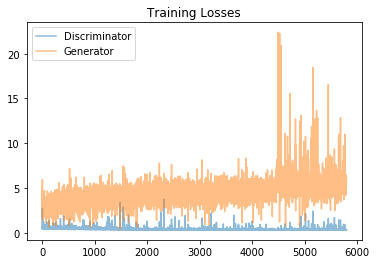

In [24]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [25]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [26]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

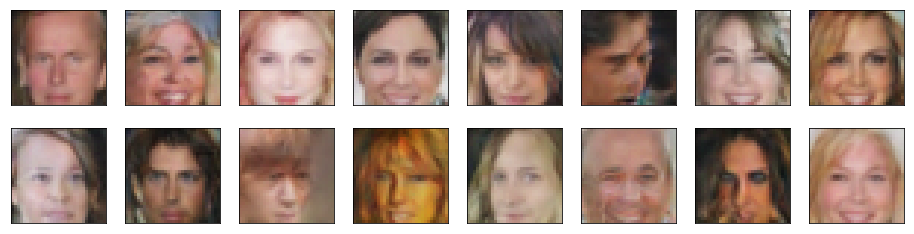

In [29]:
_ = view_samples(20, samples)

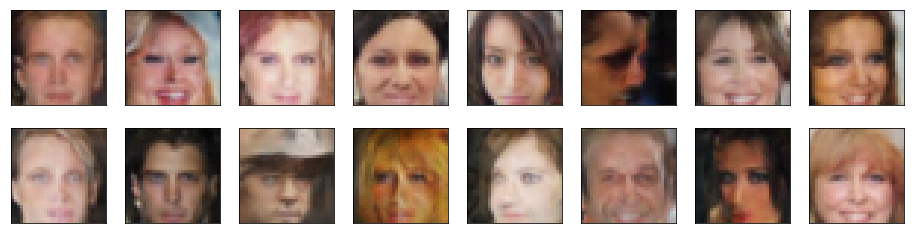

In [30]:
_ = view_samples(40, samples)

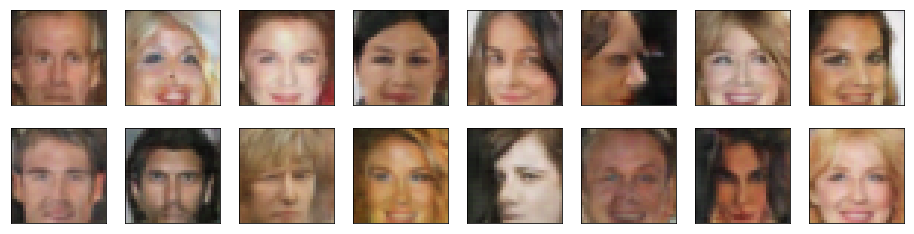

In [31]:
_ = view_samples(80, samples)

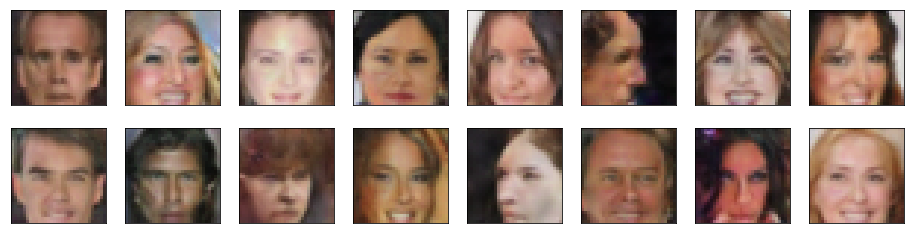

In [32]:
_ = view_samples(100, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


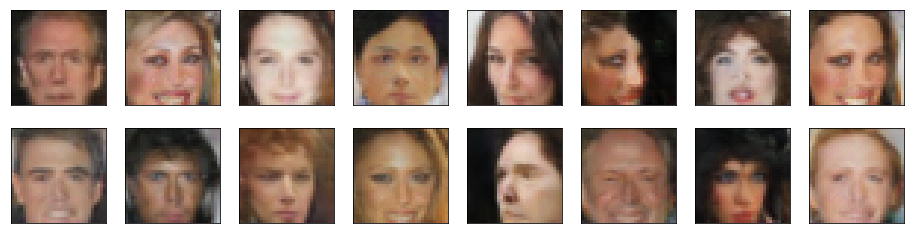

In [33]:
_ = view_samples(150, samples)

**Answer:** (Write your answer in this cell)
1. As on the question, CELEBA images are mostly whites. That means my model just learns almost whitely faces. if I add others, it'll effect my new result.
2. In this case, I used resized image from origin images(64x64). But many papers are using 64x64 image. if I use 64x64, I can add more layer and it can make better quality images. More features mean learn mores, but it required more computing power and time for learning. 
3. Epoch number 20 is better than 200 with same batch size 64. WGAN GP loss function is better than that I used one on a blog post ( https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b.)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.